### Imports

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB

### Load data

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=4000)

word_index = keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

### Create the vocabulary

In [3]:
vocabulary = list()
for text in x_train:
  tokens = text.split()
  vocabulary.extend(tokens)

vocabulary = set(vocabulary)
print("Original Vocabulary Length: ", len(vocabulary))

stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
vocabulary.difference_update(stopwords)

print("Vocabulary Length without stopwords", len(vocabulary))

Original Vocabulary Length:  3998
Vocabulary Length without stopwords 3851


### Create binary vectors

In [4]:
x_train_binary = list()
x_test_binary = list()

for text in tqdm(x_train):
  tokens = text.split()
  binary_vector = list()
  for vocab_token in vocabulary:
    if vocab_token in tokens:
      binary_vector.append(1)
    else:
      binary_vector.append(0)
  x_train_binary.append(binary_vector)

x_train_binary = np.array(x_train_binary)

for text in tqdm(x_test):
  tokens = text.split()
  binary_vector = list()
  for vocab_token in vocabulary:
    if vocab_token in tokens:
      binary_vector.append(1)
    else:
      binary_vector.append(0)
  x_test_binary.append(binary_vector)

x_test_binary = np.array(x_test_binary)

100%|██████████| 25000/25000 [04:13<00:00, 98.63it/s] 


### My Bernoulli Naive Bayes implemenation

In [33]:
class BNB():
    def __init__(self) -> None:
        self.fited = False

    def fit(self, X, Y):
        self.prior_positive, self.prior_negative = self.calculate_priors(Y)
        # positive_count = np.zeros(len(X[0]), dtype=int)
        # negative_count = np.zeros(len(X[0]), dtype=int)
        positive_count = np.ones(len(X[0]), dtype=int) #ones instead of zeros for laplace
        negative_count = np.ones(len(X[0]), dtype=int) 
        for document, label in zip(X, Y):
            for idx, word in enumerate(document):
                if label == 1:
                    positive_count[idx] += word
                else:
                    negative_count[idx] += word
        self.positive_frequencies = np.array([x/(len(X)*self.prior_positive) for x in positive_count])
        self.negative_frequencies =  np.array([x/(len(X)*self.prior_negative) for x in negative_count])
        self.fited = True

    def predict(self, X):
        if self.fited:
            predictions = list()
            for document in tqdm(X):
                positive_prediction = self.prior_positive
                negative_prediction = self.prior_negative
                for idx, word in enumerate(document):
                    if word == 1:
                        positive_prediction *= self.positive_frequencies[idx]
                        negative_prediction *= self.negative_frequencies[idx]
                    else:
                        positive_prediction *= (1 - self.positive_frequencies[idx])
                        negative_prediction *= (1 - self.negative_frequencies[idx])

                if positive_prediction >= negative_prediction:
                    predictions.append(1)
                else:
                    predictions.append(0)
            return predictions
        else:
            print("use fit first")

    def calculate_priors(self, Y):
        return np.sum(Y)/len(Y), 1 - np.sum(Y)/len(Y)

### Helper functions

In [34]:
def calculate_precision(Y, X):
    tp, fp, tn, fn = calculate_confusion(Y, X)
    return tp / (fp + tp)

def calculate_recall(Y, X):
    tp, fp, tn, fn = calculate_confusion(Y, X)
    return tp / (fn + tp)

def calculate_f1_score(Y, X):
    return 2 * calculate_precision(Y, X) * calculate_recall(Y, X) / (calculate_precision(Y, X) + calculate_recall(Y, X))

def calculate_accuracy(Y, X):
    tp, fp, tn, fn = calculate_confusion(Y, X)
    return (tp + tn) / (tp + fn + tn + fp)

def calculate_confusion(Y, X):
    tp, fp, tn, fn = 0, 0, 0, 0
    for actual, prediction in zip(Y, X):
        if actual == 1 and prediction == 1:
            tp += 1
        elif actual == 1 and prediction == 0:
            fn += 1
        elif actual == 0 and prediction == 1:
            fp += 1
        else:
            tn += 1
    return tp, fp, tn, fn


### Fit my implementation and predict in stages

In [7]:
myBNB = BNB()
accuracy = list()
precision = list()
recall = list()
f1 = list()
step_percentage = 0.1
steps = ([100, 200, 300, 400, 500, 1000, 2000] + list(range(int(len(y_train)*step_percentage) , len(y_train) + 1 , int(len(y_train)*step_percentage))))
for step in steps:
    print(step, ":")
    myBNB.fit(x_train_binary[:step], y_train[:step])
    predictions =  myBNB.predict(x_test_binary)
    print(classification_report(y_test, predictions))
    accuracy.append(calculate_accuracy(y_test, predictions))
    precision.append(calculate_precision(y_test, predictions))
    recall.append(calculate_recall(y_test, predictions))
    f1.append(calculate_f1_score(y_test, predictions))
    print("Accuracy: ", calculate_accuracy(y_test, predictions))
    print("Precision: ", calculate_precision(y_test, predictions))
    print("Recall: ", calculate_recall(y_test, predictions))
    print("F1-score: ", calculate_f1_score(y_test, predictions))

100 :


100%|██████████| 25000/25000 [01:41<00:00, 246.15it/s]


              precision    recall  f1-score   support

           0       0.52      0.96      0.67     12500
           1       0.71      0.10      0.18     12500

    accuracy                           0.53     25000
   macro avg       0.61      0.53      0.43     25000
weighted avg       0.61      0.53      0.43     25000

Accuracy:  0.53072
Precision:  0.7107574094401756
Recall:  0.1036
F1-score:  0.18084066471163243
200 :


100%|██████████| 25000/25000 [01:41<00:00, 246.51it/s]


              precision    recall  f1-score   support

           0       0.60      0.92      0.73     12500
           1       0.84      0.38      0.52     12500

    accuracy                           0.65     25000
   macro avg       0.72      0.65      0.63     25000
weighted avg       0.72      0.65      0.63     25000

Accuracy:  0.65348
Precision:  0.8356955380577428
Recall:  0.38208
F1-score:  0.5244029645896239
300 :


100%|██████████| 25000/25000 [01:41<00:00, 246.55it/s]


              precision    recall  f1-score   support

           0       0.76      0.82      0.79     12500
           1       0.81      0.74      0.77     12500

    accuracy                           0.78     25000
   macro avg       0.78      0.78      0.78     25000
weighted avg       0.78      0.78      0.78     25000

Accuracy:  0.78128
Precision:  0.8076653832691635
Recall:  0.7384
F1-score:  0.7714811099966565
400 :


100%|██████████| 25000/25000 [01:41<00:00, 245.96it/s]


              precision    recall  f1-score   support

           0       0.81      0.77      0.79     12500
           1       0.78      0.82      0.80     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000

Accuracy:  0.79532
Precision:  0.7805304354434227
Recall:  0.82168
F1-score:  0.800576795666238
500 :


100%|██████████| 25000/25000 [01:40<00:00, 248.54it/s]


              precision    recall  f1-score   support

           0       0.77      0.83      0.80     12500
           1       0.82      0.76      0.79     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000

Accuracy:  0.79284
Precision:  0.8158053662324217
Recall:  0.75648
F1-score:  0.7850234527416878
1000 :


100%|██████████| 25000/25000 [01:40<00:00, 247.99it/s]


              precision    recall  f1-score   support

           0       0.79      0.83      0.81     12500
           1       0.83      0.78      0.80     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000

Accuracy:  0.80872
Precision:  0.8254892037786775
Recall:  0.78296
F1-score:  0.8036623419280671
2000 :


100%|██████████| 25000/25000 [01:40<00:00, 247.77it/s]


              precision    recall  f1-score   support

           0       0.81      0.84      0.83     12500
           1       0.84      0.80      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

Accuracy:  0.82232
Precision:  0.8371548117154811
Recall:  0.80032
F1-score:  0.8183231083844581
2500 :


100%|██████████| 25000/25000 [01:40<00:00, 247.67it/s]


              precision    recall  f1-score   support

           0       0.81      0.85      0.83     12500
           1       0.84      0.80      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

Accuracy:  0.82304
Precision:  0.8417978669375318
Recall:  0.7956
F1-score:  0.818047215595953
5000 :


100%|██████████| 25000/25000 [01:40<00:00, 248.03it/s]


              precision    recall  f1-score   support

           0       0.83      0.84      0.83     12500
           1       0.84      0.82      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

Accuracy:  0.83252
Precision:  0.839777650617183
Recall:  0.82184
F1-score:  0.8307120042049085
7500 :


100%|██████████| 25000/25000 [01:40<00:00, 248.42it/s]


              precision    recall  f1-score   support

           0       0.83      0.84      0.84     12500
           1       0.84      0.83      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Accuracy:  0.83516
Precision:  0.8383813908408044
Recall:  0.8304
F1-score:  0.834371608858165
10000 :


100%|██████████| 25000/25000 [01:40<00:00, 248.42it/s]


              precision    recall  f1-score   support

           0       0.84      0.84      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Accuracy:  0.83892
Precision:  0.8373815401767938
Recall:  0.8412
F1-score:  0.8392864269465617
12500 :


100%|██████████| 25000/25000 [01:40<00:00, 248.13it/s]


              precision    recall  f1-score   support

           0       0.84      0.84      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Accuracy:  0.839
Precision:  0.8390813795310874
Recall:  0.83888
F1-score:  0.8389806776813218
15000 :


100%|██████████| 25000/25000 [01:40<00:00, 247.91it/s]


              precision    recall  f1-score   support

           0       0.84      0.84      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Accuracy:  0.83748
Precision:  0.8380479205064508
Recall:  0.83664
F1-score:  0.8373433684294809
17500 :


100%|██████████| 25000/25000 [01:40<00:00, 248.38it/s]


              precision    recall  f1-score   support

           0       0.84      0.84      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Accuracy:  0.83796
Precision:  0.8392355255761664
Recall:  0.83608
F1-score:  0.8376547910070934
20000 :


100%|██████████| 25000/25000 [01:40<00:00, 248.06it/s]


              precision    recall  f1-score   support

           0       0.83      0.84      0.84     12500
           1       0.84      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Accuracy:  0.83704
Precision:  0.8410231503966327
Recall:  0.8312
F1-score:  0.8360827231029211
22500 :


100%|██████████| 25000/25000 [01:42<00:00, 244.48it/s]


              precision    recall  f1-score   support

           0       0.84      0.84      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Accuracy:  0.8392
Precision:  0.8404528665489
Recall:  0.83736
F1-score:  0.8389035825919692
25000 :


100%|██████████| 25000/25000 [01:43<00:00, 241.37it/s]


              precision    recall  f1-score   support

           0       0.84      0.84      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Accuracy:  0.83924
Precision:  0.8382927802153969
Recall:  0.84064
F1-score:  0.8394647493509088


### Compare with sklearn's implementation

In [8]:
nb = BernoulliNB()
for step in steps:
    print(step, ":")
    nb.fit(x_train_binary[:step], y_train[:step])
    predictions = nb.predict(x_test_binary)
    print(classification_report(y_test, predictions))

100 :
              precision    recall  f1-score   support

           0       0.52      0.97      0.68     12500
           1       0.78      0.11      0.20     12500

    accuracy                           0.54     25000
   macro avg       0.65      0.54      0.44     25000
weighted avg       0.65      0.54      0.44     25000

200 :
              precision    recall  f1-score   support

           0       0.61      0.94      0.74     12500
           1       0.87      0.40      0.55     12500

    accuracy                           0.67     25000
   macro avg       0.74      0.67      0.65     25000
weighted avg       0.74      0.67      0.65     25000

300 :
              precision    recall  f1-score   support

           0       0.76      0.85      0.80     12500
           1       0.83      0.74      0.78     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000

4

### Generate graphs

Text(0, 0.5, 'Metrics')

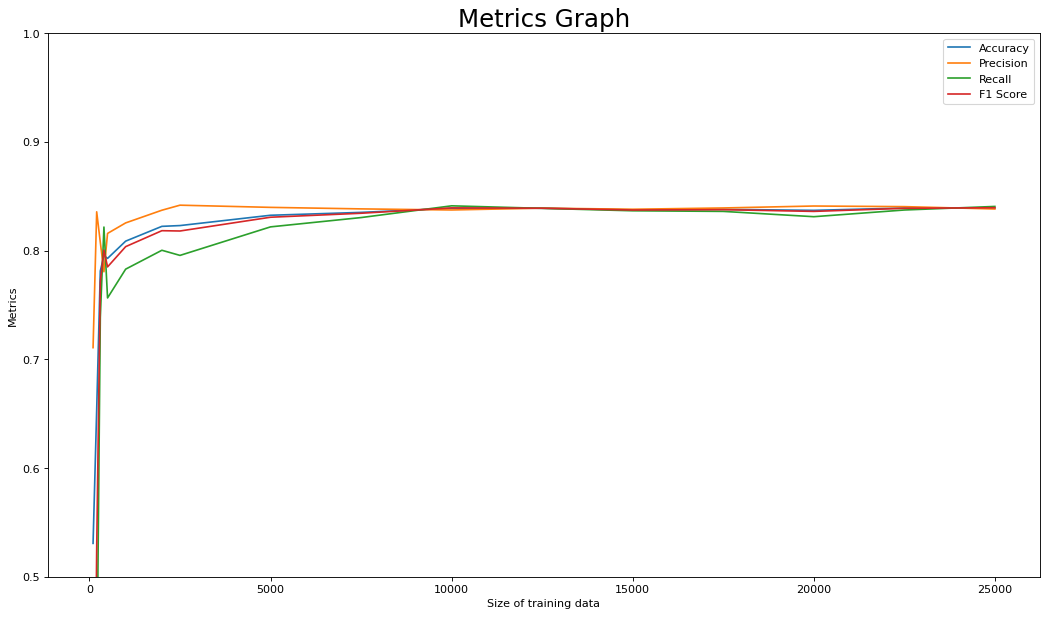

In [9]:
plt.figure(figsize=(16,9), dpi= 80)
plt.plot(steps, accuracy)
plt.plot(steps, precision)
plt.plot(steps, recall)
plt.plot(steps, f1)
plt.legend (["Accuracy", "Precision", "Recall", "F1 Score"])
plt.ylim(0.5,1)
plt.title("Metrics Graph", fontsize=22)
plt.xlabel("Size of training data")
plt.ylabel("Metrics")

### Test with 8000 words and 5000 reviews

In [38]:
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=8000)

word_index = keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

vocabulary = list()
for text in x_train:
  tokens = text.split()
  vocabulary.extend(tokens)

vocabulary = set(vocabulary)
print("Original Vocabulary Length: ", len(vocabulary))

stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
vocabulary.difference_update(stopwords)

print("Vocabulary Length without stopwords", len(vocabulary))

x_train_binary = list()
x_test_binary = list()

for text in tqdm(x_train[:5000]):
  tokens = text.split()
  binary_vector = list()
  for vocab_token in vocabulary:
    if vocab_token in tokens:
      binary_vector.append(1)
    else:
      binary_vector.append(0)
  x_train_binary.append(binary_vector)

x_train_binary = np.array(x_train_binary)

for text in tqdm(x_test[:5000]):
  tokens = text.split()
  binary_vector = list()
  for vocab_token in vocabulary:
    if vocab_token in tokens:
      binary_vector.append(1)
    else:
      binary_vector.append(0)
  x_test_binary.append(binary_vector)

x_test_binary = np.array(x_test_binary)

Original Vocabulary Length:  7997
Vocabulary Length without stopwords 7846


100%|██████████| 5000/5000 [01:46<00:00, 46.94it/s]


In [39]:
myBNB = BNB()
myBNB.fit(x_train_binary, y_train[:5000])
predictions =  myBNB.predict(x_test_binary)
print(classification_report(y_test[:5000], predictions))
print("Accuracy: ", calculate_accuracy(y_test[:5000], predictions))
print("Precision: ", calculate_precision(y_test[:5000], predictions))
print("Recall: ", calculate_recall(y_test[:5000], predictions))
print("F1-score: ", calculate_f1_score(y_test[:5000], predictions))

nb = BernoulliNB()
nb.fit(x_train_binary, y_train[:5000])
predictions = nb.predict(x_test_binary)
print(classification_report(y_test[:5000], predictions))

100%|██████████| 5000/5000 [00:43<00:00, 115.67it/s]


              precision    recall  f1-score   support

           0       0.82      0.83      0.82      2571
           1       0.82      0.81      0.81      2429

    accuracy                           0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.82      0.82      0.82      5000

Accuracy:  0.8184
Precision:  0.8154292824554127
Recall:  0.8093865788390284
F1-score:  0.8123966942148761
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      2571
           1       0.85      0.80      0.83      2429

    accuracy                           0.84      5000
   macro avg       0.84      0.83      0.84      5000
weighted avg       0.84      0.84      0.84      5000

